# Convolutional Neural Network Final Notebook

This notebook demonstrates the implementation of a Convolutional Neural Network (CNN) for image classification tasks. It includes data loading, preprocessing, model building, training, and evaluation steps.

## Import Required Libraries

We first import all necessary libraries for data processing, model training, and evaluation.

In [1]:
# Install required libraries if not already installed (if running in a new environment)
# !pip install tensorflow scikit-learn pillow matplotlib


# Import libraries for data handling, mathematical operations, and file system interactions
import os  # For interacting with the file system (e.g., directories, files)
import numpy as np  # For numerical computations and handling multi-dimensional arrays
import random  # For generating random numbers (used for data shuffling or sampling)
import math  # For performing mathematical operations

# Import libraries for visualization
import matplotlib.pyplot as plt  # For creating visualizations such as plots and graphs

# Import libraries for machine learning tasks
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report  # For evaluation metrics
from sklearn.preprocessing import LabelEncoder  # For encoding class labels into numerical format

# Import TensorFlow and Keras for building and training deep learning models
import tensorflow as tf  # Core TensorFlow library
from tensorflow.keras.models import Sequential  # Sequential model type
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Layers for building CNNs
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image augmentation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam  # Optimizer for gradient-based optimization
from tensorflow.keras.callbacks import ReduceLROnPlateau  # Callback for dynamic learning rate adjustment

# Import PIL for handling and manipulating image files
from PIL import Image  # For opening, resizing, and manipulating images


## Define the Path to the Image Dataset

We set up the base path to the dataset directory. Ensure the dataset is correctly organized into subfolders for training, validation, and testing.

In [4]:
# Set the base path to your image dataset
base_path = r"D:\UNIPROGRAM\data\data\Processed Leaf Images"

## Loading the images

This cell defines a function to load images and their corresponding labels from a specified folder. It processes only image files with specific extensions (.png, .jpg, .jpeg) and organizes them based on their class folder names. The function returns the images and their labels as NumPy arrays. After defining the function, it is used to load the dataset

In [7]:
# Function to load preprocessed images from the specified base path
def load_images_from_folder(base_path):
    """
    Loads images and their corresponding labels from a directory structure.

    Parameters:
        base_path (str): The path to the folder containing subfolders for each class.

    Returns:
        images (np.array): Array of all loaded images.
        labels (np.array): Array of labels corresponding to the class folders.
    """
    images = []  # List to store all image data
    labels = []  # List to store corresponding labels (class names)

    # Loop through each class folder in the base path
    for class_folder in os.listdir(base_path):
        class_path = os.path.join(base_path, class_folder)  # Full path of the class folder
        if os.path.isdir(class_path):  # Ensure it's a directory
            # Loop through each image file in the class folder
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)  # Full path of the image file
                # Check if the file is an image (valid extensions)
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    # Load the image and convert it to a NumPy array
                    image = np.array(Image.open(img_path))  # Open and convert image
                    images.append(image)  # Add the image to the list
                    labels.append(class_folder)  # Add the folder name as the label

    # Return the images and labels as NumPy arrays
    return np.array(images), np.array(labels)

# Load images and their labels using the defined function
images, labels = load_images_from_folder(base_path)

# Print the shape of the loaded images and labels for confirmation
print("Images loaded:", images.shape)  # Shape of the image dataset (e.g., number of images, dimensions)
print("Labels loaded:", labels.shape)  # Shape of the labels dataset (e.g., number of labels)


Images loaded: (58549, 128, 128, 3)
Labels loaded: (58549,)


## Encoding the labels

In [10]:
# Encode class labels to numerical values
# Using LabelEncoder to convert class names (text labels) into numerical format
# This is necessary for machine learning models, which work with numerical data.
label_encoder = LabelEncoder()  # Initialize the label encoder
labels_encoded = label_encoder.fit_transform(labels)  # Fit and transform the class labels

# Display the encoded labels to verify the encoding process
print("Classes:", label_encoder.classes_)  # Show the unique classes detected
print("Encoded Labels:", labels_encoded[:10])  # Display the first 10 encoded labels as a sanity check


Classes: ['Cerscospora' 'Healthy' 'Leaf rust' 'Miner' 'Phoma']
Encoded Labels: [0 0 0 0 0 0 0 0 0 0]


## Split Data into Training and Testing Sets

This cell is responsible for splitting the dataset into training and testing subsets. The split ensures that the class distribution remains consistent across both subsets using stratification.

In [13]:
# Split the dataset into training and testing sets
# - `train_test_split` is used to split the data into two subsets: training and testing.
# - `images`: The input feature data (images of leaves).
# - `labels_encoded`: The encoded labels for the images.
# - `test_size=0.2`: 20% of the data is allocated to the testing set, while the remaining 80% goes to the training set.
# - `stratify=labels_encoded`: Ensures that the class distribution in the training and testing sets is the same as in the original dataset.
# - `random_state=42`: Sets a fixed random seed for reproducibility of results.

X_train, X_test, y_train, y_test = train_test_split(
    images, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42
)

# Display the shapes of the split data to verify the split
# - This ensures the data has been divided correctly and the dimensions align with expectations.
print("Training data shape:", X_train.shape)  # Shape of the training data
print("Testing data shape:", X_test.shape)  # Shape of the testing data


Training data shape: (46839, 128, 128, 3)
Testing data shape: (11710, 128, 128, 3)


## Data Augmentation and visualization
This cell sets up data augmentation for the training dataset using TensorFlow's `ImageDataGenerator`. It also visualizes the augmented images for various classes to ensure that the augmentations are applied correctly.


Fitting the data generator to X_train...
Fetching a sample batch from the data generator to verify...
Sample batch (X) shape: (32, 128, 128, 3), Sample batch (y) shape: (32,)


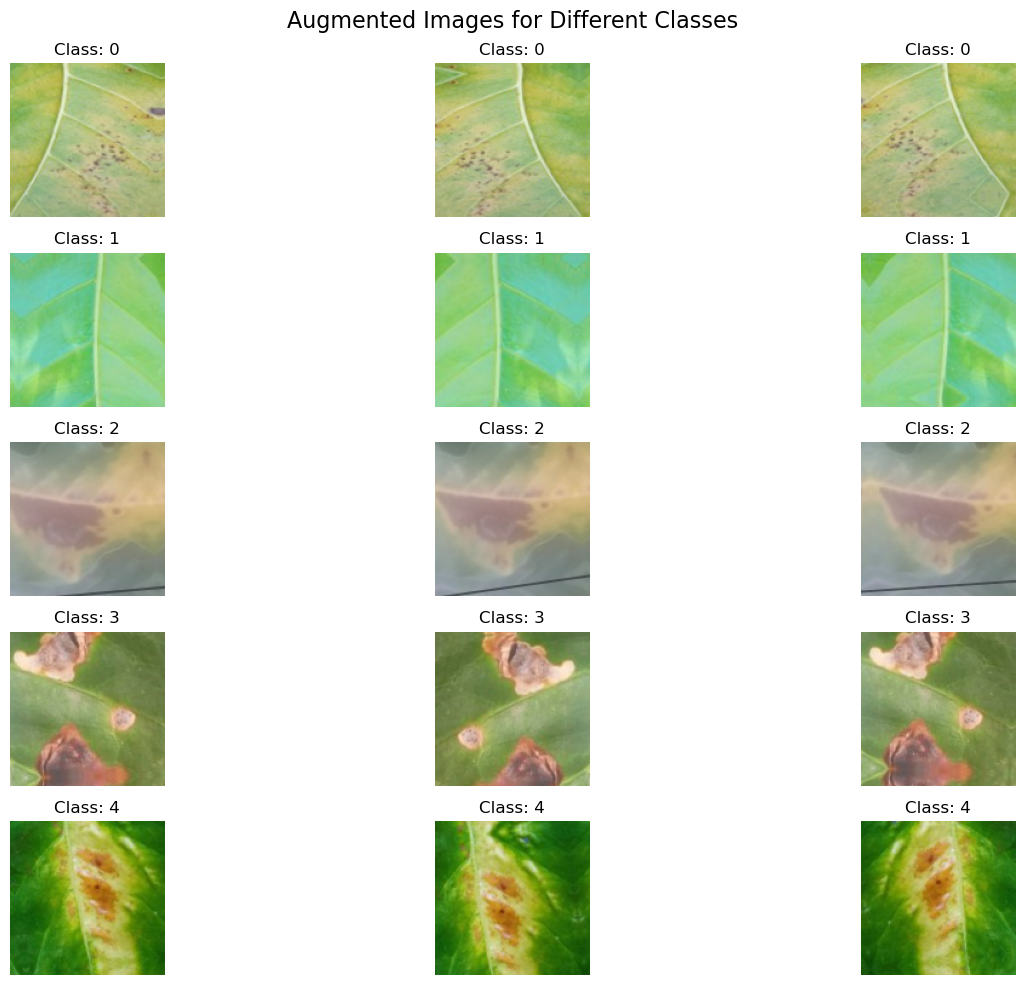

In [16]:
# Define the ImageDataGenerator with reduced augmentation
datagen = ImageDataGenerator(
    rotation_range=10,           # Mild rotation for variability in image orientation
    width_shift_range=0.1,       # Allow small horizontal shifts to simulate natural variability
    height_shift_range=0.1,      # Allow small vertical shifts to simulate natural variability
    shear_range=0.05,            # Minimal shearing to slightly distort the perspective
    zoom_range=0.05,             # Small zoom variations to retain patterns while adding diversity
    horizontal_flip=True,        # Randomly flip images horizontally to increase data diversity
    fill_mode='reflect'          # Handle empty pixels by reflecting the edge pixels
)

# Fit the generator to your training data
# - Ensures that the data generator computes the statistics of the training data (e.g., mean, standard deviation)
# - Useful when applying normalization or transformations based on the dataset's statistics.
print("Fitting the data generator to X_train...")
datagen.fit(X_train)

# Debug: Fetch a sample batch from the data generator to verify
# - Checks that the generator is functioning correctly by fetching one batch of data.
train_generator = datagen.flow(X_train, y_train, batch_size=32)
sample_batch = next(train_generator)  # Fetch the next batch
print(f"Sample batch (X) shape: {sample_batch[0].shape}, Sample batch (y) shape: {sample_batch[1].shape}")

# Visualize augmented images for different classes
# - Selects a few random images from the training set for each unique class.
# - Applies the data augmentation pipeline to these images and displays augmented versions.

# Identify the unique classes in the training set
unique_classes = np.unique(y_train)
num_classes_to_visualize = len(unique_classes)  # Number of classes to visualize

# Create a figure for visualizing augmentations
plt.figure(figsize=(15, 10))

for i, class_label in enumerate(unique_classes):
    # Find indices of all images belonging to the current class
    class_indices = np.where(y_train == class_label)[0]
    
    # Randomly select one image from the current class
    random_index = np.random.choice(class_indices)
    sample_image = X_train[random_index]  # Select the corresponding image
    
    # Create a generator to apply augmentations to the sample image
    augmented_generator = datagen.flow(
        sample_image.reshape((1,) + sample_image.shape),  # Add batch dimension to the image
        batch_size=1  # Generate one augmented image at a time
    )
    
    # Generate and display 3 augmented versions for the current class
    for j in range(3):  # Display 3 augmentations for each class
        augmented_image = next(augmented_generator)[0].astype("uint8")  # Generate augmented image
        plt.subplot(num_classes_to_visualize, 3, i * 3 + j + 1)  # Subplot arrangement
        plt.imshow(augmented_image)  # Display the augmented image
        plt.title(f"Class: {class_label}")  # Add class label as title
        plt.axis("off")  # Turn off axes for cleaner visualization

# Add a title to the overall figure and adjust layout
plt.suptitle("Augmented Images for Different Classes", fontsize=16)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()  # Display the figure


## Define the CNN Model

This cell defines and initializes a Convolutional Neural Network (CNN) architecture for classifying the dataset. The model is designed with techniques like Batch Normalization, Dropout, and L2 Regularization to improve training stability and prevent overfitting. A summary of the model is also displayed to confirm its structure.

In [19]:
# Define the CNN architecture with improvements
model = Sequential([
    Input(shape=(128, 128, 3)),  # Input layer for images of shape 128x128 with 3 color channels (RGB)
    
    # First convolutional block
    Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),  # 16 filters, 3x3 kernel, ReLU activation, L2 regularization
    BatchNormalization(),  # Normalize activations to improve training stability
    MaxPooling2D(pool_size=(2, 2)),  # Downsample the feature map by 2x2 pooling
    Dropout(0.3),  # Dropout to prevent overfitting by randomly deactivating neurons during training
    
    # Second convolutional block
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),  # 32 filters, 3x3 kernel, ReLU activation, L2 regularization
    BatchNormalization(),  # Normalize activations to improve training stability
    MaxPooling2D(pool_size=(2, 2)),  # Downsample the feature map by 2x2 pooling
    Dropout(0.3),  # Dropout to prevent overfitting
    
    # Flattening and fully connected layers
    Flatten(),  # Flatten the feature map into a 1D vector
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Fully connected layer with 64 neurons and ReLU activation
    Dropout(0.5),  # Dropout to prevent overfitting
    
    # Output layer
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with number of classes; softmax for probabilities
])

# Display the model summary
# - Prints a summary of the model architecture, including layers, output shapes, and number of parameters
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,848,869 (7.05 MB)

 Trainable params: 1,848,773 (7.05 MB)

 Non-trainable params: 96 (384.00 B)

##  Learning Rate Tuning

This cell compiles the CNN model with an Adam optimizer, specifying the loss function and evaluation metrics. It also defines a learning rate scheduler callback (ReduceLROnPlateau) to adjust the learning rate dynamically during training if the validation loss plateaus.

In [22]:

# Compile the model with a reduced learning rate
optimizer = Adam(learning_rate=0.00005)  # Adam optimizer with a small learning rate for fine-tuned updates
model.compile(
    optimizer=optimizer,  # Set the optimizer for weight updates
    loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification with integer labels
    metrics=['accuracy']  # Evaluation metric to track during training
)

# Define callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss to trigger learning rate adjustments
    factor=0.5,          # Reduce the learning rate by half when triggered
    patience=3,          # Wait for 3 epochs without improvement before adjusting
    min_lr=1e-6          # Set a minimum learning rate to prevent overly small updates
)


## Training the model: Session 1

This cell initializes the data generator for augmenting the training data, verifies the batch shapes and data types, ensures compatibility by converting data types, and trains the model for the first 15 epochs. It also utilizes a learning rate scheduler (lr_scheduler) to dynamically adjust the learning rate during training.

In [25]:
# Debug: Confirm the data generator output
train_generator = datagen.flow(X_train, y_train, batch_size=32)  # Generates augmented data batches
X_batch, y_batch = next(train_generator)  # Fetch a sample batch for debugging
# print(f"Batch X shape: {X_batch.shape}, dtype: {X_batch.dtype}")  # Print shape and dtype of input batch
# print(f"Batch y shape: {y_batch.shape}, dtype: {y_batch.dtype}")  # Print shape and dtype of label batch

# Ensure types are correct
X_train = X_train.astype("float32")  # Convert training data to float32 for TensorFlow compatibility
y_train = y_train.astype("int64")  # Convert training labels to int64 for compatibility with sparse loss functions
X_test = X_test.astype("float32")  # Convert test data to float32 for TensorFlow compatibility
y_test = y_test.astype("int64")  # Convert test labels to int64 for compatibility with sparse loss functions

# Train the model for the first 15 epochs
history_1 = model.fit(
    train_generator,  # Use the data generator for training with augmented data
    validation_data=(X_test, y_test),  # Use test data for validation
    epochs=15,  # Train for 15 epochs in the first session
    callbacks=[lr_scheduler]  # Use the learning rate scheduler for dynamic adjustments
)


Batch X shape: (32, 128, 128, 3), dtype: float32
Batch y shape: (32,), dtype: int64
Epoch 1/15


D:\UNIPROGRAM\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1464/1464 ━━━━━━━━━━━━━━━━━━━━ 134s 90ms/step - accuracy: 0.7673 - loss: 0.8377 - val_accuracy: 0.8975 - val_loss: 0.4778 - learning_rate: 5.0000e-05
Epoch 2/15
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 125s 85ms/step - accuracy: 0.8985 - loss: 0.4107 - val_accuracy: 0.9571 - val_loss: 0.3066 - learning_rate: 5.0000e-05
Epoch 3/15
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 123s 84ms/step - accuracy: 0.9346 - loss: 0.3258 - val_accuracy: 0.9559 - val_loss: 0.2961 - learning_rate: 5.0000e-05
Epoch 4/15
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 122s 83ms/step - accuracy: 0.9519 - loss: 0.2751 - val_accuracy: 0.9796 - val_loss: 0.2087 - learning_rate: 5.0000e-05
Epoch 5/15
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 123s 84ms/step - accuracy: 0.9610 - loss: 0.2456 - val_accuracy: 0.9880 - val_loss: 0.1646 - learning_rate: 5.0000e-05
Epoch 6/15
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 123s 84ms/step - accuracy: 0.9666 - loss: 0.2275 - val_accuracy: 0.9833 - val_loss: 0.1739 - learning_rate: 5.0000e-05
Epoch 7/15
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 123

In [26]:
# Save the model weights after the first training session
model.save_weights("model_weights_session_1.weights.h5")
print("First training session completed. Model weights saved.")


First training session completed. Model weights saved.


In [27]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


366/366 - 3s - 7ms/step - accuracy: 0.9958 - loss: 0.1048
Test accuracy: 0.9958155155181885


## Plot Training History for session 1

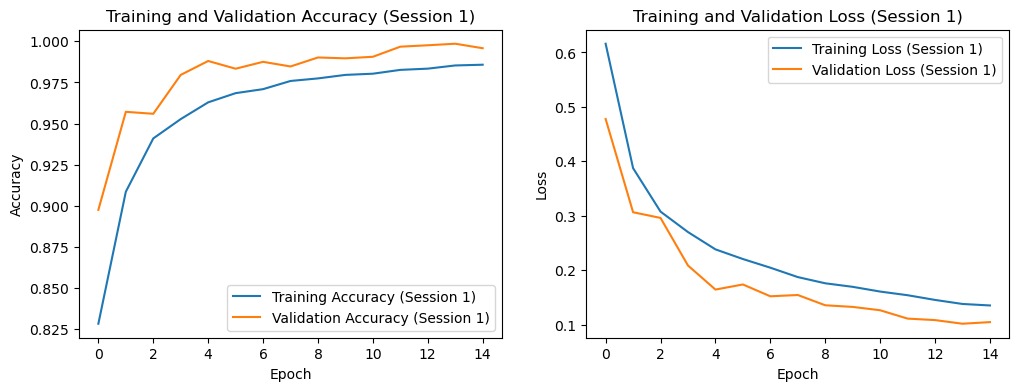

In [29]:
# Plot the accuracy and loss for the first training session
plt.figure(figsize=(12, 4))  # Create a figure with a specified size

# Accuracy Plot
plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(history_1.history['accuracy'], label='Training Accuracy (Session 1)')  # Plot training accuracy
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy (Session 1)')  # Plot validation accuracy
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.legend()  # Add a legend to distinguish training and validation accuracy
plt.title('Training and Validation Accuracy (Session 1)')  # Title for the accuracy plot

# Loss Plot
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(history_1.history['loss'], label='Training Loss (Session 1)')  # Plot training loss
plt.plot(history_1.history['val_loss'], label='Validation Loss (Session 1)')  # Plot validation loss
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend()  # Add a legend to distinguish training and validation loss
plt.title('Training and Validation Loss (Session 1)')  # Title for the loss plot

plt.show()  # Display the plots


## second training session

In [33]:
# Load the model weights saved from the first session
model.load_weights("model_weights_session_1.weights.h5")
print("Model weights loaded from the first session.")

# Train the model for another 15 epochs
history_2 = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=15,
    callbacks=[lr_scheduler]
)



Model weights loaded from the first session.
Epoch 1/15
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 125s 85ms/step - accuracy: 0.9865 - loss: 0.1284 - val_accuracy: 0.9929 - val_loss: 0.1046 - learning_rate: 5.0000e-05
Epoch 2/15
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 123s 84ms/step - accuracy: 0.9873 - loss: 0.1230 - val_accuracy: 0.9953 - val_loss: 0.0980 - learning_rate: 5.0000e-05
Epoch 3/15
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 124s 85ms/step - accuracy: 0.9868 - loss: 0.1238 - val_accuracy: 0.9993 - val_loss: 0.0857 - learning_rate: 5.0000e-05
Epoch 4/15
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 124s 85ms/step - accuracy: 0.9872 - loss: 0.1208 - val_accuracy: 0.9985 - val_loss: 0.0860 - learning_rate: 5.0000e-05
Epoch 5/15
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 124s 84ms/step - accuracy: 0.9881 - loss: 0.1156 - val_accuracy: 0.9983 - val_loss: 0.0824 - learning_rate: 5.0000e-05
Epoch 6/15
1464/1464 ━━━━━━━━━━━━━━━━━━━━ 124s 85ms/step - accuracy: 0.9876 - loss: 0.1144 - val_accuracy: 0.9949 - val_loss: 0.0892 - learning_rate: 

## Save the Trained Model
After training and evaluation, we save the trained model to a file. This allows us to reuse the model later without retraining it. The model is saved in TensorFlow's SavedModel format.

In [35]:
# Save the model weights after the second session (optional)
model.save_weights("model_weights_session_2.weights.h5")
print("Second training session completed. Model weights saved.")


Second training session completed. Model weights saved.


## Evaluate the Model after second training session

In [37]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


366/366 - 3s - 7ms/step - accuracy: 0.9985 - loss: 0.0757
Test accuracy: 0.9985482692718506


## Plot Training History for session 2

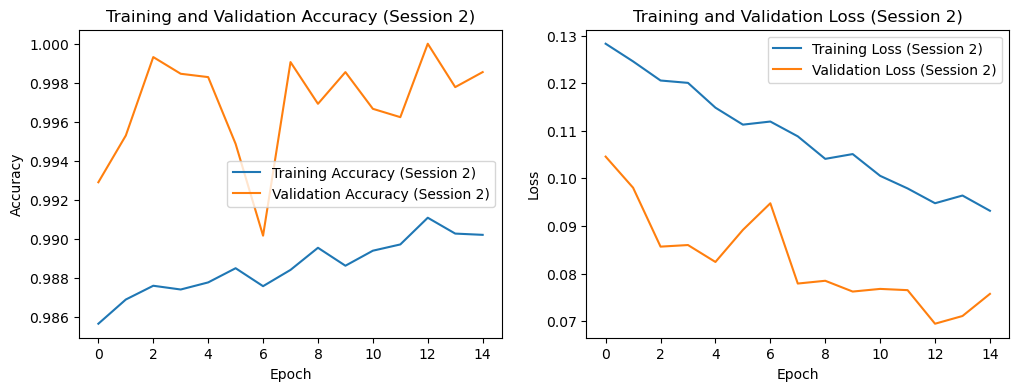

In [43]:
# Plot the accuracy and loss for the first training session
plt.figure(figsize=(12, 4))  # Create a figure with a specified size

# Accuracy Plot
plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(history_1.history['accuracy'], label='Training Accuracy (Session 1)')  # Plot training accuracy
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy (Session 1)')  # Plot validation accuracy
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.legend()  # Add a legend to distinguish training and validation accuracy
plt.title('Training and Validation Accuracy (Session 1)')  # Title for the accuracy plot

# Loss Plot
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(history_1.history['loss'], label='Training Loss (Session 1)')  # Plot training loss
plt.plot(history_1.history['val_loss'], label='Validation Loss (Session 1)')  # Plot validation loss
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend()  # Add a legend to distinguish training and validation loss
plt.title('Training and Validation Loss (Session 1)')  # Title for the loss plot

plt.show()  # Display the plots


## Make Predictions with the Trained Model



### Cell Description:
This cell contains two main functions for sampling and visualizing images:

1. **`sample_random_images`**:
   - This function samples a specified number of random images from each class in the dataset.
   - It groups the images by their class labels, randomly selects images from each class, and returns the sampled images along with their corresponding labels.

2. **`display_sampled_images`**:
   - This function visualizes the sampled images in a grid layout.
   - Each image is displayed with its corresponding label as the title, allowing for an intuitive examination of the dataset.

#### Workflow:
1. Randomly sample images from the dataset using `sample_random_images`:
   - Groups images by their classes.
   - Selects up to `num_images_per_class` images for each class.

2. Visualize the sampled images using `display_sampled_images`:
   - Dynamically determines the grid layout based on the number of images.
   - Displays the images in a well-structured grid with their labels as titles.


#### Expected Output:
- A grid visualization showing a random subset of images from each class, with their respective labels displayed as titles.


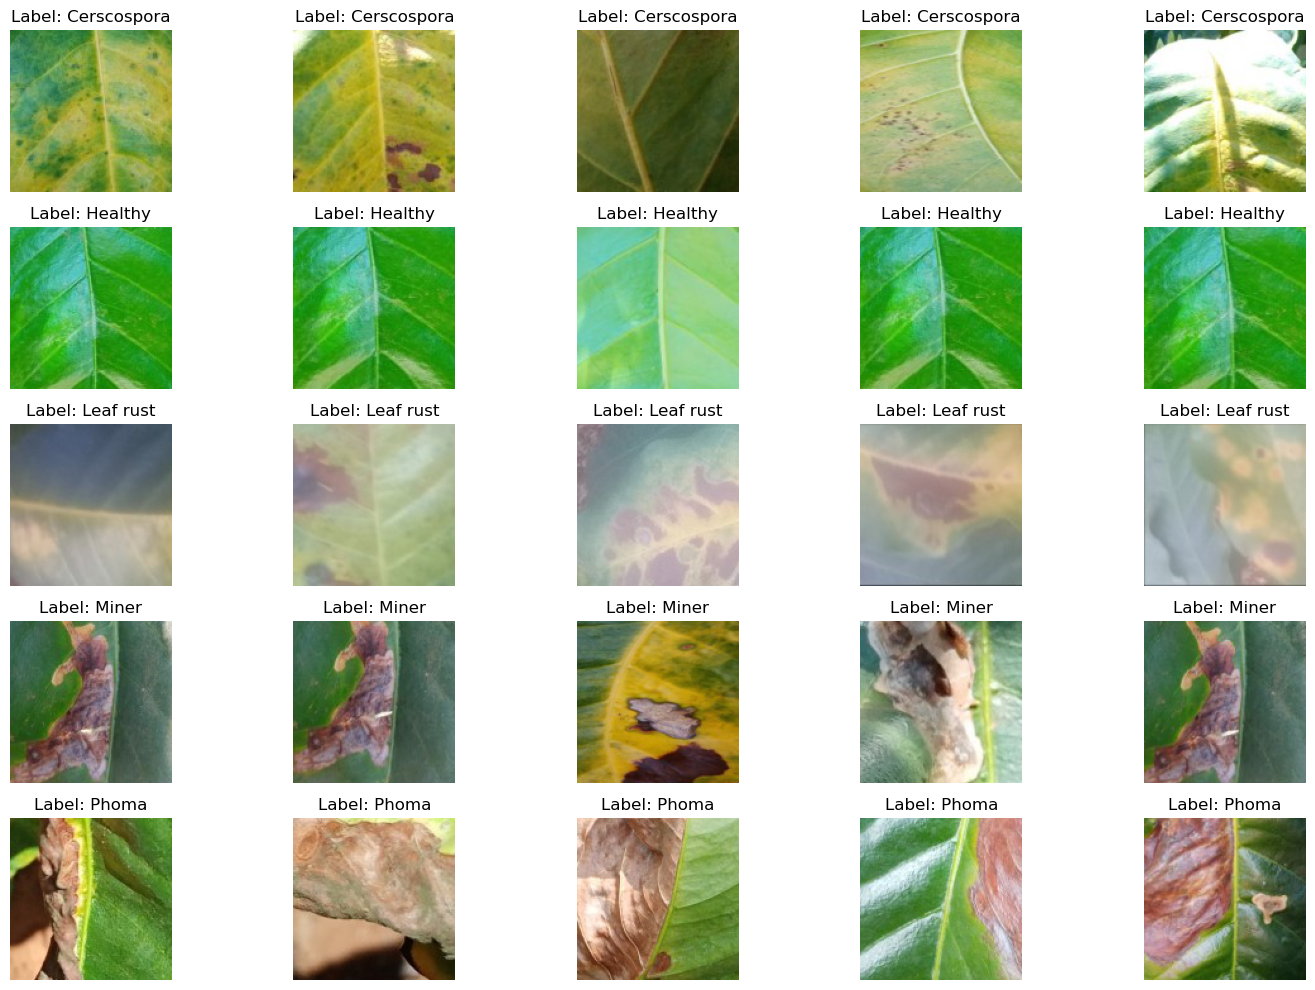

In [47]:
def sample_random_images(images, labels, num_images_per_class=5):
    """
    Samples a specified number of random images from each class.

    Args:
        images (numpy array): Array of all images in the dataset.
        labels (numpy array): Array of labels corresponding to the images.
        num_images_per_class (int): Number of images to sample per class.

    Returns:
        sampled_images (numpy array): Randomly sampled images from each class.
        sampled_labels (numpy array): Corresponding labels for the sampled images.
    """
    class_images = {}  # Dictionary to store images grouped by their class
    sampled_images = []  # List to store sampled images
    sampled_labels = []  # List to store labels of sampled images
    
    # Group images by their class
    for img, label in zip(images, labels):
        if label not in class_images:
            class_images[label] = []  # Initialize a list for a new class
        class_images[label].append(img)  # Add the image to its class group
    
    # Randomly select images from each class
    for label, imgs in class_images.items():
        # Randomly sample a fixed number of images or all available images if fewer exist
        sampled = random.sample(imgs, min(num_images_per_class, len(imgs)))
        sampled_images.extend(sampled)  # Add sampled images to the result list
        sampled_labels.extend([label] * len(sampled))  # Add corresponding labels
    
    return np.array(sampled_images), np.array(sampled_labels)  # Convert lists to numpy arrays

# Sample random images and their labels
random_images, random_labels = sample_random_images(images, labels)
# print statements can be uncommented for debugging:
# print("Sampled random images:", random_images.shape)
# print("Sampled random labels:", random_labels)


def display_sampled_images(images, labels):
    """
    Displays the sampled images in a grid layout with their labels.

    Args:
        images (numpy array): Array of sampled images to be displayed.
        labels (numpy array): Corresponding labels for the sampled images.
    """
    num_images = len(images)  # Total number of sampled images
    cols = 5  # Number of columns in the grid
    rows = math.ceil(num_images / cols)  # Calculate the required number of rows dynamically

    plt.figure(figsize=(15, 10))  # Create a figure with an appropriate size
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)  # Create a subplot for each image
        plt.imshow(images[i])  # Display the image
        plt.title(f"Label: {labels[i]}")  # Display the label as the title
        plt.axis('off')  # Hide axes for a cleaner look

    plt.tight_layout()  # Adjust spacing between subplots for better visibility
    plt.show()  # Render the visualization

# Display the sampled random images with their labels
display_sampled_images(random_images, random_labels)


### Cell Description:
This cell utilizes the trained model to predict the class labels of a random subset of images from the dataset. It compares the predicted labels with the true labels and displays them, providing insights into the model's performance on unseen data.

#### Workflow:
1. **Predict Classes**:
   - Use the trained model to predict the class probabilities for the sampled random images.
2. **Convert Predictions**:
   - Convert the predicted probabilities into class labels by selecting the class with the highest probability (`np.argmax`).
   - Map the numerical labels back to their corresponding class names using the label encoder.
3. **Display Results**:
   - Print the true class label and the predicted class label for each sampled image for comparison.

#### Purpose:
- To evaluate the model's ability to correctly classify a random subset of images.
- To manually verify the predicted labels against the true labels.

#### Key Features:
- **Prediction**: Predicts class probabilities using the trained model.
- **Mapping**: Converts numerical predictions into readable class names.
- **Comparison**: Outputs a side-by-side comparison of true and predicted labels for better interpretability.

#### Expected Output:
- A printed list of true labels and their corresponding predicted labels, enabling a quick manual assessment of the model's accuracy.





In [73]:
# Use the trained model to predict the classes of the random images
predictions = model.predict(random_images)

# Convert the predicted probabilities to class labels by selecting the class with the highest probability
predicted_labels = [label_encoder.classes_[np.argmax(pred)] for pred in predictions]

# Display the true labels and their corresponding predicted labels for comparison
for i in range(len(random_images)):
    print(f"True Label: {random_labels[i]}, Predicted Label: {predicted_labels[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
True Label: Cerscospora, Predicted Label: Cerscospora
True Label: Cerscospora, Predicted Label: Cerscospora
True Label: Cerscospora, Predicted Label: Cerscospora
True Label: Cerscospora, Predicted Label: Cerscospora
True Label: Cerscospora, Predicted Label: Cerscospora
True Label: Healthy, Predicted Label: Healthy
True Label: Healthy, Predicted Label: Healthy
True Label: Healthy, Predicted Label: Healthy
True Label: Healthy, Predicted Label: Healthy
True Label: Healthy, Predicted Label: Healthy
True Label: Leaf rust, Predicted Label: Leaf rust
True Label: Leaf rust, Predicted Label: Leaf rust
True Label: Leaf rust, Predicted Label: Leaf rust
True Label: Leaf rust, Predicted Label: Leaf rust
True Label: Leaf rust, Predicted Label: Leaf rust
True Label: Miner, Predicted Label: Miner
True Label: Miner, Predicted Label: Miner
True Label: Miner, Predicted Label: Miner
True Label: Miner, Predicted Label: Miner
True Label: Miner, Predicted Label: Miner
Tr

### Cell Description:
This cell visualizes a random subset of images along with their true labels and predicted labels. It creates a grid of images where each image is annotated with both its true class label and the label predicted by the trained model. This visualization helps to assess the model's performance in an intuitive and interpretable way.

#### Workflow:
1. **Define Plotting Function**:
   - A function `plot_random_images_with_labels` is defined to plot the random images, true labels, and predicted labels.
   - The function dynamically adjusts the grid layout based on the number of images to ensure a clean and organized display.
2. **Plot Images**:
   - Each image is plotted alongside its true and predicted labels.
   - Titles above each image display the true label and the predicted label for easy comparison.
3. **Display Grid**:
   - The grid layout dynamically adjusts the rows and columns for an aesthetically pleasing visualization.

#### Purpose:
- To provide a visual representation of the model's predictions for a random set of images.
- To allow for quick verification of the model's accuracy by visually comparing predictions against true labels.

#### Key Features:
- **Dynamic Layout**: Automatically adjusts the number of rows based on the number of images.
- **Annotated Titles**: Displays both true and predicted labels for each image.
- **User-Friendly Visualization**: A clean grid layout for better interpretability.

#### Expected Output:
- A grid of images with true labels and predicted labels displayed above each image. This allows for an easy, visual evaluation of the model's classification accuracy.




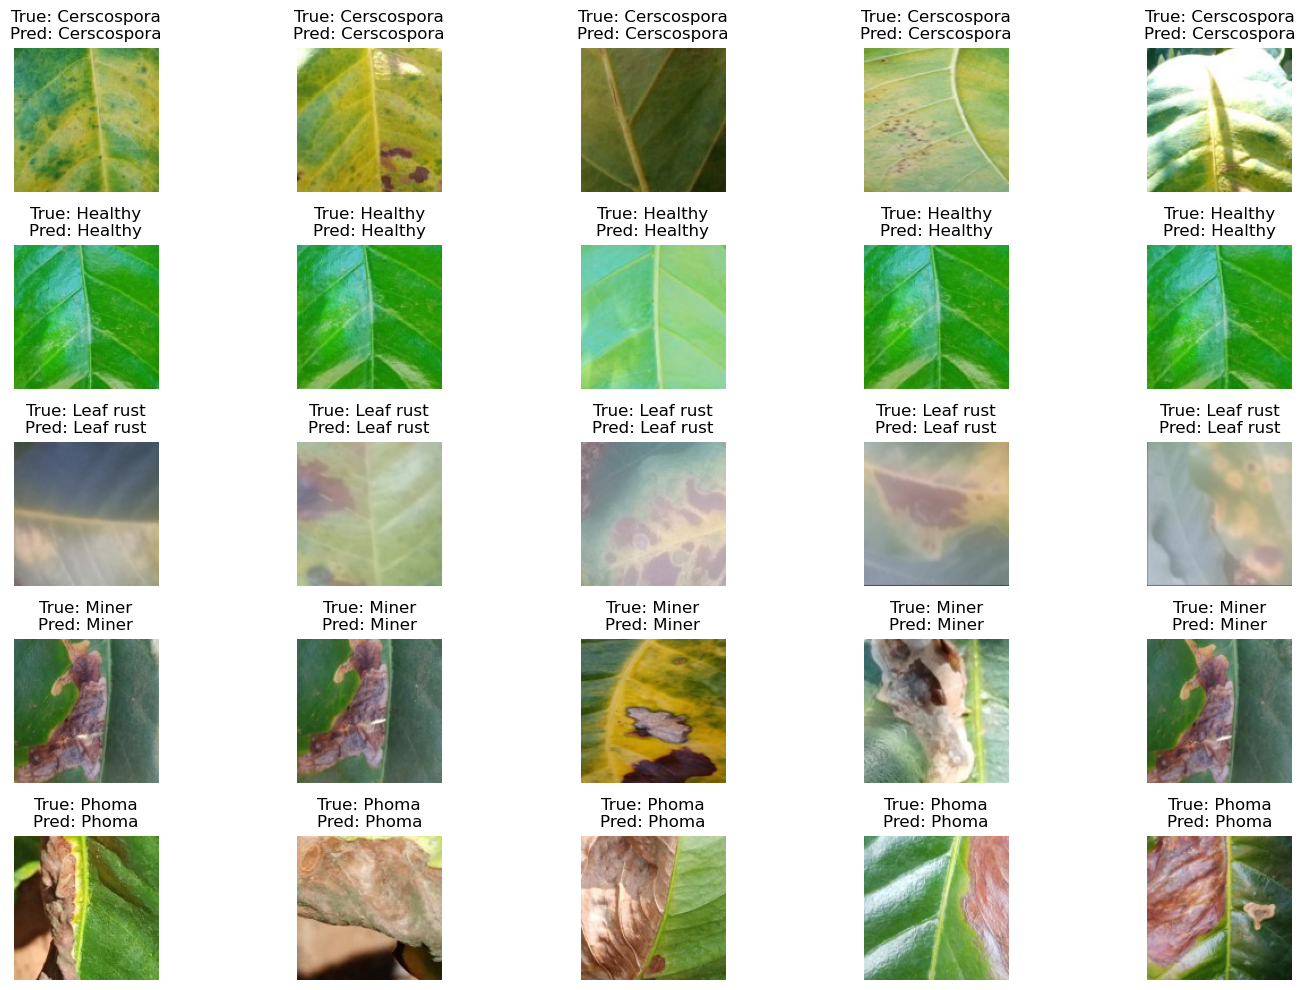

In [78]:
# Define a function to plot images with their true and predicted labels
def plot_random_images_with_labels(images, true_labels, predicted_labels):
    num_images = len(images)  # Total number of images to display
    cols = 5  # Set a fixed number of columns
    rows = math.ceil(num_images / cols)  # Dynamically calculate the required number of rows

    # Create a new figure for plotting
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)  # Add a subplot for each image
        plt.imshow(images[i])  # Display the image
        # Annotate the image with its true label and predicted label
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')  # Hide the axis for better visualization

    # Adjust the layout to prevent overlapping of images and labels
    plt.tight_layout()
    plt.show()

# Call the function to plot random images with their true and predicted labels
plot_random_images_with_labels(random_images, random_labels, predicted_labels)


### Cell Description:
This cell generates and visualizes the confusion matrix and classification report for the model's predictions on a random set of images. These tools provide detailed insights into the model's performance by showing the distribution of correct and incorrect predictions for each class.

#### Workflow:
1. **Generate Confusion Matrix**:
   - `confusion_matrix` function is used to compute the confusion matrix, which shows how often each class is correctly or incorrectly predicted.
2. **Visualize Confusion Matrix**:
   - The confusion matrix is displayed using `ConfusionMatrixDisplay` for better interpretability.
   - The matrix is styled with a blue color map and vertically rotated x-tick labels for clarity.
3. **Generate Classification Report**:
   - A detailed classification report is generated using `classification_report`, which provides metrics such as precision, recall, F1-score, and support for each class.
4. **Output**:
   - A visual confusion matrix that highlights the distribution of predictions for each class.
   - A textual classification report summarizing the model's performance metrics.

#### Purpose:
- **Confusion Matrix**:
  - Helps in understanding which classes the model confuses most often.
  - Provides an intuitive visualization of model performance across all classes.
- **Classification Report**:
  - Gives detailed metrics for each class, making it easy to identify strengths and weaknesses in the model's predictions.



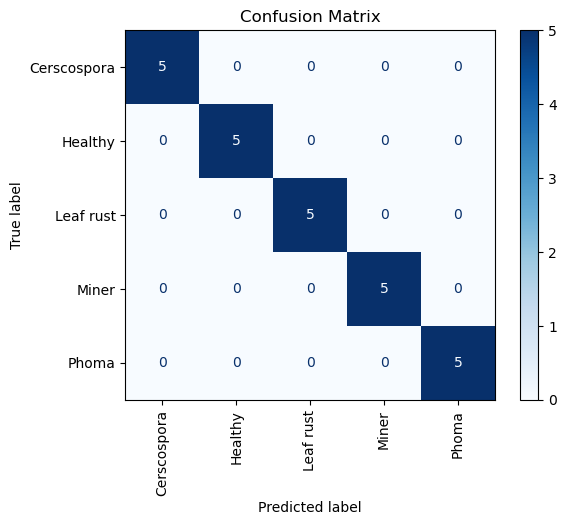

Classification Report:

              precision    recall  f1-score   support

 Cerscospora       1.00      1.00      1.00         5
     Healthy       1.00      1.00      1.00         5
   Leaf rust       1.00      1.00      1.00         5
       Miner       1.00      1.00      1.00         5
       Phoma       1.00      1.00      1.00         5

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



In [63]:
# Generate the confusion matrix based on true and predicted labels
cm = confusion_matrix(random_labels, predicted_labels, labels=label_encoder.classes_)

# Visualize the confusion matrix for easy interpretation
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')  # Use a blue color map and rotate x-ticks vertically

# Add a title for clarity
plt.title("Confusion Matrix")
plt.show()

# Generate and display a detailed classification report
# Includes metrics like precision, recall, F1-score, and support for each class
report = classification_report(random_labels, predicted_labels, target_names=label_encoder.classes_)
print("Classification Report:\n")
print(report)


# Conclusion

This notebook demonstrates the complete pipeline for building, training, and evaluating a CNN for image classification. Key steps included:
- Data preprocessing and augmentation
- Model building and compilation
- Training, evaluation, and visualization
- Saving the model and making predictions

For further improvement, we should consider hyperparameter tuning or experimenting with advanced architectures.